<a href="https://colab.research.google.com/github/isabellebouchard/inf8225_tp/blob/master/Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO
- fix data augmention class ImgAugTransform since its performing worse when applying data aug. 





# Part II (20 points)

For this part, you may work in groups of 2. Each person submits their own report, but for this part the reports
have to be identical if you work in a group.

The objective of Part II is to familiarize yourself with the Pytorch library (or Tensorflow + Keras, or your choice
of other software). You will experiment with Fashion MNIST. This is a dataset of images similar to MNIST, but
consisting of 10 different categories of clothing.

- Perform experiments with different architectures; e.g. use different types and numbers of layers. - DONE
- Use at least one convolutional network and one fully connected network.  - DONE
- Use a validation set to select the best architecture, and use the test set only at the end.  - DONE
- Compare your results based on learning curves and log-probability.  - DONE
- You can refer to code available here: https://github.com/AlexPiche/INF8225/tree/master/tp2, and also to pytorch
tutorials here: https://github.com/MaximumEntropy/pytorch_notebooks

Submit a report including the learning curves and code of your models.






# Installation Requirements

In [1]:
# imgaug requirements
!pip3 install six numpy scipy Pillow scikit-image opencv-python imageio Shapely
!pip3 install torch torchvision matplotlib imgaug>=0.2.7,<0.2.8




/bin/bash: 0.2.8: No such file or directory


#Use GPU 

First, select "GPU" in the Edit Menu -> Notebook Settings -> Hardware Accelerator -> GPU

**torch.cuda**: *This package adds support for CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation.*

**torch.cuda.is_available()**: *Returns a bool indicating if CUDA is currently available.*

To go from a tensor type CPU to GPU, add .to("cuda:0")

In [2]:
import torch

use_gpu = torch.cuda.is_available()
print("GPU Available: {}".format(use_gpu))
device = torch.device("cuda:0" if use_gpu else "cpu")
device

GPU Available: True


device(type='cuda', index=0)

# Hyperparameters



In [0]:
learning_rate = 1e-2
batch_size = 16

# Fashion-MNIST Dataset

**Fashion-MNIST** is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

### Dataset Split
**train_set**: 0.80*(60,000) = 48,000

**valid_set**: 60,000 - 48,000 = 12,000

**test_set**: 10,000



In [0]:
from torchvision.datasets.mnist import MNIST

#FashionMNIST class is from: https://github.com/AlexPiche/INF8225/blob/master/tp2/fashion.py
class FashionMNIST(MNIST):
    """`Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
            ]


# Data Augmentation
To prevent overfitting, we augmented our data in the training set by doing rotations, horizontal flips, resize crops, etc.. We also normalized the data in training, validation, and test sets. 

In [0]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((98, 98)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)]))
        #iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return Image.fromarray(self.aug.augment_image(img))

In [6]:
import torch
import torchvision
from torch.utils.data import sampler, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
import imgaug as ia
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F

def load_dataset(batch_size, data_transforms, data_path='../data'):
  # ChunkSampler class is from https://github.com/pytorch/vision/issues/168
  class ChunkSampler(sampler.Sampler):
      """Samples elements sequentially from some offset.
      Arguments:
          num_samples: # of desired datapoints
          start: offset where we should start selecting from
      """

      def __init__(self, num_samples, start=0):
          self.num_samples = num_samples
          self.start = start

      def __iter__(self):
          return iter(range(self.start, self.start + self.num_samples))

      def __len__(self):
          return self.num_samples

  train_set = FashionMNIST(root=data_path, train=True, transform=data_transforms['aug_false'], download=True)
  aug_train_set = FashionMNIST(root=data_path, train=True, transform=data_transforms['aug_true'], download=True)
  test_set = FashionMNIST(root=data_path, train=False, transform=data_transforms['test'], download=True)
    
  train_set_size = len(train_set)
  NUM_TRAIN = int(0.8 * train_set_size)  # cast to int to avoid TypeError
  NUM_VAL = train_set_size - NUM_TRAIN
  NUM_TEST = len(test_set)

  trainset = DataLoader(aug_train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0), shuffle=False, num_workers=8)
  validset = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN), shuffle=False, num_workers=8)
  testset = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

  print("Data Loading Complete!")

  return trainset, validset, testset

# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'aug_true': transforms.Compose([
        ImgAugTransform(),
        transforms.Resize([28,28]),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    'aug_false': transforms.Compose([
        transforms.Resize([28,28]),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    'test': transforms.Compose([
        transforms.Resize([28,28]),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
}

train_set, valid_set, test_set = load_dataset(batch_size, data_transforms)

print('Train_size',len(train_set) * batch_size)
print('Val_size',len(valid_set) * batch_size)
print('Test_size',len(test_set) * batch_size)

Processing...
Done!
Data Loading Complete!
Train_size 48000
Val_size 12000
Test_size 10000


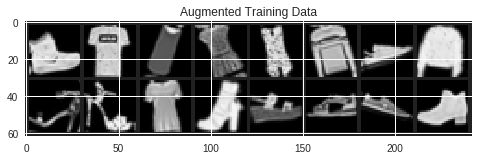

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1307])
    std = np.array([0.3081])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_set))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="Augmented Training Data")

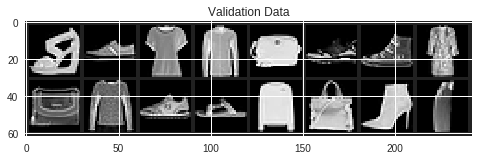

In [8]:
# Get a batch of training data
inputs, classes = next(iter(valid_set))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="Validation Data")

# Create Models

[torch.nn.Module](https://pytorch.org/docs/master/nn.html#torch.nn.Module): Base class for all NN modules. 
Must implement __init__ (defines the layers) and **forward** (returns the output)

[torch.nn.Sequential(*args)](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential): Modules will be added to it in the order they are passed in the constructor

 [torch.nn.Conv2d](https://pytorch.org/docs/master/nn.html#torch.nn.Conv2d)(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
 
[torch.nn.MaxPool2d](https://pytorch.org/docs/master/nn.html#torch.nn.MaxPool2d)(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False): Applies a 2D max pooling over an input signal composed of several input planes.

 [torch.nn.Linear](https://pytorch.org/docs/master/nn.html#torch.nn.Linear)(in_features, out_features, bias=True)


In [0]:
import torch.nn as nn
import copy
import torch

class shallow_CNN(nn.Module):
  def __init__(self):
    super(shallow_CNN, self).__init__()
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=5,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=5,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())

    self.conv3 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=5,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv4 = nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.fc = nn.Linear(2*2*256,10)
    
  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    flatten = out.view(out.size(0),-1)
    fc = self.fc(flatten)
    return fc


class deep_CNN(nn.Module):
  def __init__(self):
    super(deep_CNN, self).__init__()
    
    self.conv1 = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=5,padding=2),
        nn.Conv2d(32,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=5,padding=2),
        nn.Conv2d(64,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())

    self.conv3 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=5,padding=2),
        nn.Conv2d(128,128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.conv4 = nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=2),
        nn.Conv2d(256,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d())
    
    self.fc = nn.Linear(2*2*256,10)
    
  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    flatten = out.view(out.size(0),-1)
    fc = self.fc(flatten)
    return fc


class shallow_FcNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = torch.sigmoid(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    

class deep_FcNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 10)
    
    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    

#Train and Validate Model

#### Loss function

criterion = [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss)(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

#### Minimize loss function using stochastic gradient descent
optimizer = [torch.optim.SGD](https://pytorch.org/docs/master/optim.html#torch.optim.SGD)(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)

In [0]:
def experiment(model,init_model_wts, loader_train, loader_val,num_epochs=10, lr=1e-2):  
  import time

  patience = 0

  #loss function
  criterion = nn.CrossEntropyLoss()  

  #optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  model.load_state_dict(init_model_wts)
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  train_errors = []
  eval_errors = []
  acc = []

  print("Training begins...")
  since = time.time()

  for epoch in range(num_epochs):

    train_error = 0
    train_num = 0

    # model in train mode
    model.train()

    for digits, labels in loader_train:

      # digits and labels on GPU
      digits = digits.to(device)
      labels = labels.to(device)

      # zero gradient buffer
      optimizer.zero_grad()

      # forward pass
      outputs = model(digits)

      # loss function
      loss = criterion(outputs,labels)

      # backward pass
      loss.backward()

      # gradient descent step
      optimizer.step()

      # add the loss
      train_error += loss.item()
      train_num += 1

    eval_error = 0
    eval_num = 0
    correct = 0
    total = 0

    # model in eval mode
    model.eval()

    for digits, labels in loader_val:

      # digits and labels on GPU
      digits = digits.to(device)
      labels = labels.to(device)

      # forward pass
      outputs = model(digits)
      _, predicted = torch.max(outputs.data, 1)

      # loss function
      loss = criterion(outputs,labels)

      # add the loss
      eval_error += loss.item()
      eval_num += 1

      # save the accuary
      total += labels.size(0)
      correct += torch.sum(predicted == labels.data)

    #calculate epoch accuracy
    accuracy = (100 * correct)/total

    # deep copy the model of best epoch accuracy
    if accuracy > best_acc:
      best_acc = accuracy
      best_model_wts = copy.deepcopy(model.state_dict())
      patience = 0
    else:
      patience += 1
    if patience == 3:
      learning_rate /= 2
    if patience > 4:
      print('early stopping')
      break

    # save the loss
    train_errors.append(train_error / train_num)
    eval_errors.append(eval_error / eval_num)

    acc.append(accuracy)

    #print stats after each epoch
    print('\nEpoch {}'.format(epoch + 1))
    print('\nPatience {}'.format(patience))
    print('\tTrain error: {:.4f}'.format(train_error/train_num))  
    print('\tEval error: {:.4f}'.format(eval_error/eval_num))
    print('\tAccuracy on Eval set: {:.2f}%'.format(accuracy))

  time_elapsed = time.time() - since
  print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, accuracy, train_errors, eval_errors


# Plot Train and Valid Errors

In [0]:
def plot_learning_curves(train_errors,eval_errors):  
  import matplotlib.pyplot as plt
  %matplotlib inline

  # Plot training and validation curve
  x = list(range(len(train_errors))) 
  plt.plot(x, train_errors,'m',label='Train')
  plt.plot(x, eval_errors,'g', label='Validation')

  plt.xlabel('Number Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='best',shadow=True, fancybox=True)
  plt.title("Loss")

  plt.show()

# Test Model

In [0]:
def test(model,test_set):
  # model in eval mode
  model.eval()

  correct = 0
  total = 0

  for digits, labels in test_set:

    # digits and labels on GPU
    digits = digits.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(digits)
    _, predicted = torch.max(outputs.data, 1)

    # save the accuary

    total += labels.size(0)
    correct += torch.sum(predicted == labels.data)
  print("\nBest Model is: ")
  print(model)
  print('\n\nAccuracy on the test set of Best Model: {:.2f}%'.format(100 * correct / total))
  

# Run Experiment to Find and Test Best Model

shallow_FcNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


# Parameters:  407050
Training begins...

Epoch 1

Patience 0
	Train error: 1.0171
	Eval error: 0.7059
	Accuracy on Eval set: 74.00%

Epoch 2

Patience 0
	Train error: 0.7206
	Eval error: 0.6259
	Accuracy on Eval set: 77.00%

Epoch 3

Patience 0
	Train error: 0.6552
	Eval error: 0.5899
	Accuracy on Eval set: 78.00%

Epoch 4

Patience 0
	Train error: 0.6184
	Eval error: 0.5673
	Accuracy on Eval set: 79.00%

Epoch 5

Patience 1
	Train error: 0.5930
	Eval error: 0.5504
	Accuracy on Eval set: 79.00%

Epoch 6

Patience 0
	Train error: 0.5733
	Eval error: 0.5368
	Accuracy on Eval set: 80.00%

Epoch 7

Patience 1
	Train error: 0.5570
	Eval error: 0.5253
	Accuracy on Eval set: 80.00%

Epoch 8

Patience 0
	Train error: 0.5428
	Eval error: 0.5154
	Accuracy on Eval set: 81.00%

Epoch 9

Patience 1
	Train error: 0.5300
	Eval error: 0.5065
	Accuracy on Ev

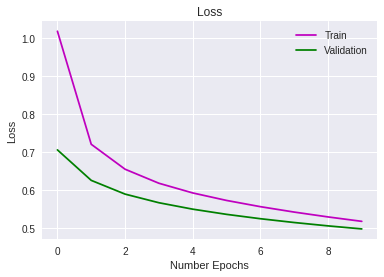

deep_FcNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)


# Parameters:  937482
Training begins...

Epoch 1

Patience 0
	Train error: 1.6513
	Eval error: 1.1301
	Accuracy on Eval set: 56.00%

Epoch 2

Patience 0
	Train error: 1.0375
	Eval error: 0.8398
	Accuracy on Eval set: 70.00%

Epoch 3

Patience 0
	Train error: 0.8399
	Eval error: 0.7247
	Accuracy on Eval set: 73.00%

Epoch 4

Patience 0
	Train error: 0.7553
	Eval error: 0.6711
	Accuracy on Eval set: 75.00%

Epoch 5

Patience 0
	Train error: 0.7058
	Eval error: 0.6363
	Accuracy on Eval set: 76.00%

Epoch 6

Patience 0
	Train error: 0.6701
	Eval error: 0.6105
	Accuracy on Eval set: 77.00%

Epoch 7

Patience 0
	Train error: 0.6423
	Eval error: 0.5904
	Accuracy on Eval set: 78.00%

Epoch 8

Patience 1
	Train error: 0.6201
	Eval error: 0.5742
	Accuracy on Eval set: 78.00%

Epoch 9

Patien

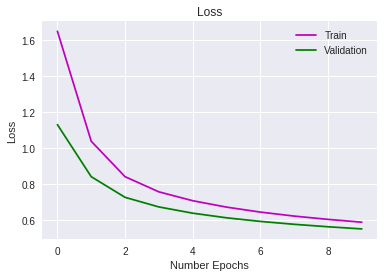

shallow_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.5)
  )
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)


# Parame

In [0]:
best_precision = 0
for model in [shallow_FcNetwork(),deep_FcNetwork(),shallow_CNN(),deep_CNN()]:  # add your models in the list
    # put model on GPU
    model = model.to(device)
    print(model)
    print("\n\n# Parameters: ", sum([param.nelement() for param in model.parameters()]))
    init_model_wts = copy.deepcopy(model.state_dict())
    model, precision, train_errors, eval_errors = experiment(model,init_model_wts, train_set, valid_set)
    plot_learning_curves(train_errors,eval_errors)
    if precision > best_precision:
        best_precision = precision
        best_model = model

print('Best Eval Accuracy of Best Model: {:.2f}%'.format(best_precision))
test(best_model, test_set)

# Discussion

## Discussion

CNN's need significantly less parameters than MLP to be able to match an MLP's performance since they exhibit sparse connectivity and parameter sharing. 

**Sparse connectivity**: direct connections very sparse, but in the deeper layers, units are indirectly connected to all/most of the input image. 

**Parameter sharing**: each member of the kernel is used at every position of the input, meaning the same parameters are used at all input locations. Therefore you learn only one set of parameters. 

This means that a CNN with roughly the same number of parameters should outperform a MLP, which is what you see in our results.

## Performance

If m represents the size of the input image, and n the size of the output image, then MLP requires mxn parameters with O(mxn) runtime. In CNNs, you limit the number of connections of each output to k, this means you only need kxn parameters with O(kxn) runtime. 

## Hyperparameter Settings

```
|   lr   |   bs   |    loss        | test accur. | epochs |        comments       
----------------------------------------------------------------------------------
|  1e-2  |   16   |CrossEntropyLoss|    83%      |   10   | with patience         
|  1e-2  |   34   |CrossEntropyLoss|    80%      |   10   | with patience         
|  1e-2  |   150  |CrossEntropyLoss|    68%      |   10   | with patience         
|  5e-3  |   16   |CrossEntropyLoss|    80%      |   10   | with patience         
|  5e-3  |   34   |CrossEntropyLoss|    73%      |   10   | with patience         
|  5e-3  |   150  |CrossEntropyLoss|    62%      |   10   | with patience         
|  1e-2  |   16   |CrossEntropyLoss|    89%      |   10   | with patience and data aug 
```






